In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pandas as pd
from ast import literal_eval

from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report, roc_curve)

from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                              GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE



In [44]:
# Load train and test data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Display the first few rows
df_train.head()
df_test.head()

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,52685,36,Male,13,Healthcare,8029,Excellent,High,Average,1,...,1,Mid,Large,22,No,No,No,Poor,Medium,Stayed
1,30585,35,Male,7,Education,4563,Good,High,Average,1,...,4,Entry,Medium,27,No,No,No,Good,High,Left
2,54656,50,Male,7,Education,5583,Fair,High,Average,3,...,2,Senior,Medium,76,No,No,Yes,Good,Low,Stayed
3,33442,58,Male,44,Media,5525,Fair,Very High,High,0,...,4,Entry,Medium,96,No,No,No,Poor,Low,Left
4,15667,39,Male,24,Education,4604,Good,High,Average,0,...,6,Mid,Large,45,Yes,No,No,Good,High,Stayed


# EDA (Exploratory Data ANalysis)

        Employee ID           Age  Years at Company  Monthly Income  \
count  14900.000000  14900.000000      14900.000000    14900.000000   
mean   37339.022081     38.385235         15.592416     7287.306040   
std    21453.129293     12.097904         11.133792     2156.737934   
min        5.000000     18.000000          1.000000     1226.000000   
25%    18825.500000     28.000000          7.000000     5633.750000   
50%    37433.000000     38.000000         13.000000     7332.000000   
75%    55857.500000     49.000000         23.000000     8852.000000   
max    74471.000000     59.000000         51.000000    15063.000000   

       Number of Promotions  Distance from Home  Number of Dependents  \
count          14900.000000        14900.000000          14900.000000   
mean               0.834362           49.927315              1.659329   
std                0.996511           28.702307              1.545401   
min                0.000000            1.000000              0.00000

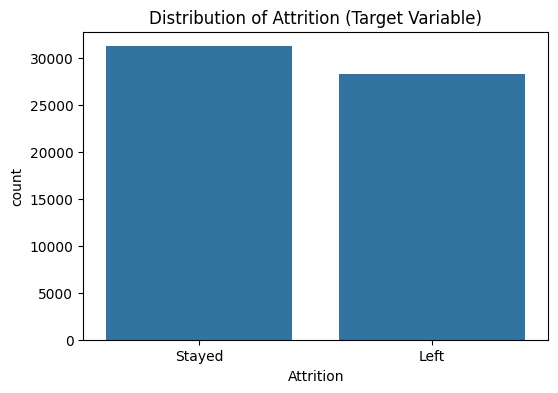

In [45]:
print(df_test.describe())
print(df_train.describe())

# Check for missing values
print(df_train.isnull().sum())
print(df_test.isnull().sum())

# Visualize the distribution of the target variable (Attrition)
plt.figure(figsize=(6, 4))
sns.countplot(x='Attrition', data=df_train)
plt.title('Distribution of Attrition (Target Variable)')
plt.show()

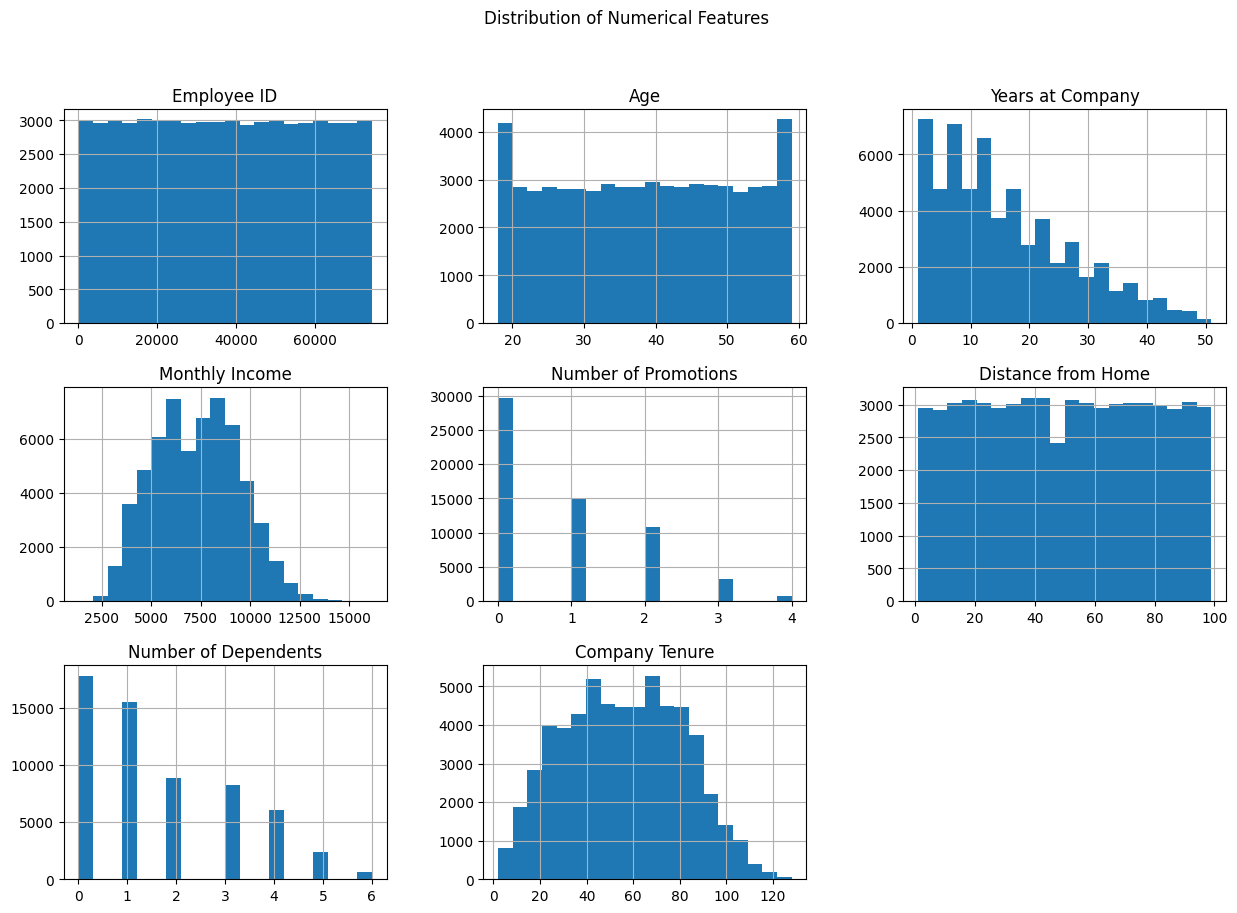

In [46]:
numerical_features = df_train.select_dtypes(include=[np.number]).columns
df_train[numerical_features].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.show()

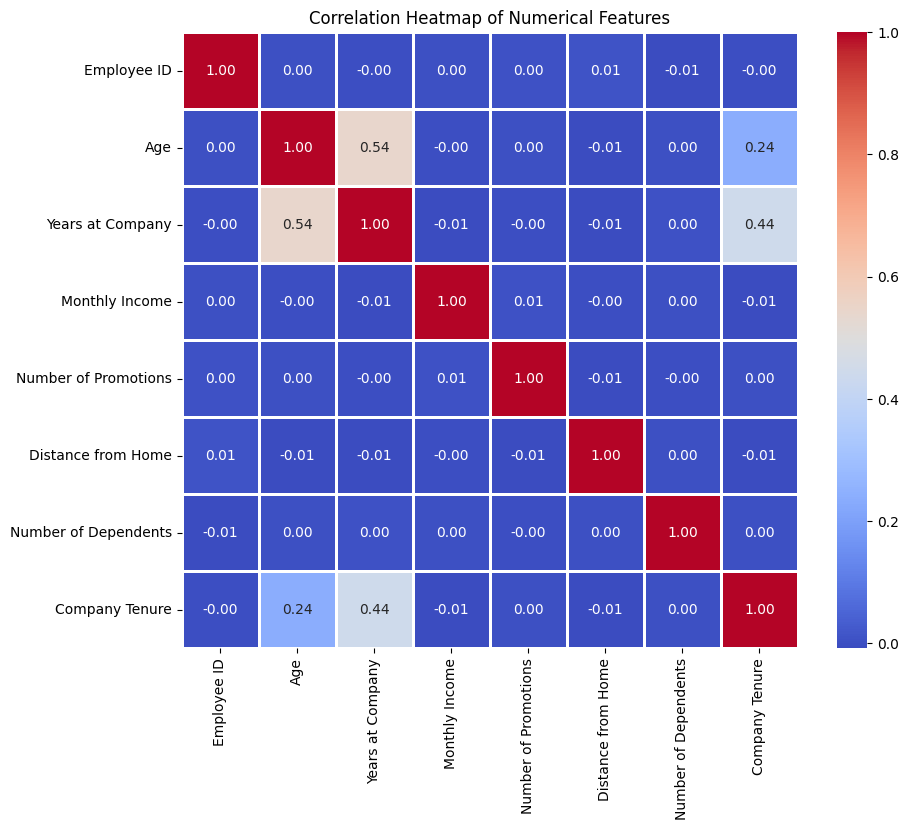

In [47]:
plt.figure(figsize=(10, 8))
corr_matrix = df_train[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [48]:
print(df_train.columns)

Index(['Employee ID', 'Age', 'Gender', 'Years at Company', 'Job Role',
       'Monthly Income', 'Work-Life Balance', 'Job Satisfaction',
       'Performance Rating', 'Number of Promotions', 'Overtime',
       'Distance from Home', 'Education Level', 'Marital Status',
       'Number of Dependents', 'Job Level', 'Company Size', 'Company Tenure',
       'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities',
       'Company Reputation', 'Employee Recognition', 'Attrition'],
      dtype='object')


# Preprocessing
## Handle Missing Values

In [49]:
# Automatically identify categorical and numerical columns
cat_cols_train = df_train.select_dtypes(include=['object']).columns
num_cols_train = df_train.select_dtypes(include=['int64', 'float64']).columns

df_train[num_cols_train] = df_train[num_cols_train].fillna(df_train[num_cols_train].median())
for col in cat_cols_train:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

df_test[num_cols_train] = df_test[num_cols_train].fillna(df_train[num_cols_train].median())
for col in cat_cols_train:
    df_test[col] = df_test[col].fillna(df_train[col].mode()[0])

# One-hot encode categorical columns
df_train_encoded = pd.get_dummies(df_train, columns=cat_cols_train, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=cat_cols_train, drop_first=True)
    
# Reindex test set to match train set
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)

In [50]:
# Scale numerical features (excluding the target column "Attrition")
num_cols_encoded = [col for col in df_train_encoded.columns if df_train_encoded[col].dtype in ["int64", "float64"] and col != "Attrition"]
scaler = StandardScaler()
df_train_encoded[num_cols_encoded] = scaler.fit_transform(df_train_encoded[num_cols_encoded])
df_test_encoded[num_cols_encoded] = scaler.transform(df_test_encoded[num_cols_encoded])

df_train_encoded.head()
df_test_encoded.head()

,Employee ID,Age,Years at Company,Monthly Income,Number of Promotions,Distance from Home,Number of Dependents,Company Tenure,Gender_Male,Job Role_Finance,...,Remote Work_Yes,Leadership Opportunities_Yes,Innovation Opportunities_Yes,Company Reputation_Fair,Company Reputation_Good,Company Reputation_Poor,Employee Recognition_Low,Employee Recognition_Medium,Employee Recognition_Very High,Attrition_Stayed
0,0.718337,-0.212414,-0.244881,0.337728,0.168266,1.159000,-0.416588,-1.328503,True,False,...,False,False,False,False,False,True,False,True,False,True
1,-0.308663,-0.295199,-0.778409,-1.273286,0.168266,0.175378,1.511835,-1.131736,True,False,...,False,False,False,False,True,False,False,False,False,False
2,0.809931,0.946567,-0.778409,-0.799185,2.178351,-1.264926,0.226220,0.796572,True,False,...,False,False,True,False,True,False,True,False,False,True
3,-0.175897,1.608842,2.511683,-0.826144,-0.836777,-0.246174,1.511835,1.583636,True,False,...,False,False,False,False,False,True,True,False,False,False
4,-1.001912,0.035939,0.733255,-1.254229,-0.836777,-0.105657,2.797450,-0.423378,True,False,...,True,False,False,False,True,False,False,False,False,True


In [51]:
# Separate features and target
X_train = df_train_encoded.drop('Attrition_Stayed', axis=1)
y_train = df_train_encoded["Attrition_Stayed"]
X_test = df_test_encoded.drop("Attrition_Stayed", axis=1)
y_test = df_test_encoded["Attrition_Stayed"]

# Model Training and Evaluation

In [52]:
# Oversample the training data using SMOTE
smote = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Calculate scale_pos_weight from original training data
counter_train = Counter(y_train)
scale_pos_weight = counter_train[0] / counter_train[1]

In [53]:
# Initialize models
models_untuned= {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight={0:1, 1:10}),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, scale_pos_weight=scale_pos_weight)}

results_untuned = []

In [54]:
'''
# Evaluation function
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    print(f"----- {name} -----")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, zero_division=0))
    print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))
    if y_pred_prob is not None:
        print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("\n")
'''

'\n# Evaluation function\ndef evaluate_model(name, model, X_test, y_test):\n    y_pred = model.predict(X_test)\n    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None\n    print(f"----- {name} -----")\n    print("Accuracy:", accuracy_score(y_test, y_pred))\n    print("Precision:", precision_score(y_test, y_pred, zero_division=0))\n    print("Recall:", recall_score(y_test, y_pred, zero_division=0))\n    print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))\n    if y_pred_prob is not None:\n        print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))\n    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))\n    print("\n")\n'

In [55]:
for name, model in models_untuned.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    results_untuned.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None
    })

print("Untuned Models Performance:")
print(pd.DataFrame(results_untuned))

c:\Users\Aweso\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:00:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Untuned Models Performance:
               Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0      Random Forest  0.742483   0.790627  0.696873  0.740796  0.834627
1  Gradient Boosting  0.757584   0.779485  0.754321  0.766697  0.850599
2            XGBoost  0.752081   0.781799  0.735892  0.758151  0.845632


In [ ]:
'''
# Parameter grids for each model
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [{0:1, 1:10}, {0:1, 1:20}]
}
 
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb_param_grid = {
    'n_estimators': [100, 200], # Number of trees (boosting rounds)
    'max_depth': [3, 5, 7], # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2], # Shrinkage parameter that controls the contibution of each tree
    'subsample': [0.8, 1.0], # Fraction of samples used for fitting each tree
    'colsample_bytree': [0.8, 1.0], # Fraction of features used for each tree
    'min_child_weight': [1, 5, 10], # Minimum sum of instance weights (hessian) in a child
    'gamma': [0, 0.1, 0.5], # Minimum loss reduction required to make a further partition on a lead node.
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight * 2] # Adjusts weight of the positive class
}
'''

In [ ]:
# loads csv for each model to get parameters from
def load_param_grid(file_path):
    df_params = pd.read_csv(file_path)
    param_grid = {}
    for _, row in df_params.iterrows():
        param = row['parameter']
        values = row.drop('parameter').dropna().tolist()
        converted_values = []
        for val in values:
            if isinstance(val, str):
                val = val.strip()
                if val == "None":
                    converted_values.append(None)
                elif val.startswith("{") and val.endswith("}"):
                    try:
                        converted_values.append(literal_eval(val))
                    except Exception:
                        converted_values.append(val)
                else:
                    try:
                        converted_values.append(int(val))
                    except ValueError:
                        try:
                            converted_values.append(float(val))
                        except ValueError:
                            converted_values.append(val)
            else:
                converted_values.append(val)
        param_grid[param] = converted_values
    return param_grid

In [ ]:
# Updates parameters so the model can continue to train and improve
def update_csv_param_grid(file_path, best_params):
    df = pd.read_csv(file_path)
    new_rows = []
    for _, row in df.iterrows():
        param = row['parameter']
        if param in best_params:
            best_val = best_params[param]
            if isinstance(best_val, (int, float)) and best_val is not None:
                delta = 0.1 * best_val  # 10% variation
                if isinstance(best_val, int):
                    candidates = [int(round(best_val - delta)), best_val, int(round(best_val + delta))]
                else:
                    candidates = [round(best_val - delta, 4), round(best_val, 4), round(best_val + delta, 4)]
            else:
                candidates = [best_val]
            new_row = {'parameter': param}
            for i, cand in enumerate(candidates, start=1):
                new_row[f'value{i}'] = cand
            new_rows.append(new_row)
        else:
            new_rows.append(row.to_dict())
    new_df = pd.DataFrame(new_rows)
    new_df.to_csv(file_path, index=False)
    print(f"Updated parameter grid saved to {file_path}")

In [57]:
# Initialize base models for tuning
rf_base = RandomForestClassifier(random_state=42)
gb_base = GradientBoostingClassifier(random_state=42)
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

In [58]:
# Tune each model
rf_grid = GridSearchCV(rf_base, rf_param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
rf_grid.fit(X_train_res, y_train_res)
print("Best parameters for Random Forest:", rf_grid.best_params_)

gb_grid = GridSearchCV(gb_base, gb_param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
gb_grid.fit(X_train_res, y_train_res)
print("Best parameters for Gradient Boosting:", gb_grid.best_params_)

xgb_grid = GridSearchCV(xgb_base, xgb_param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_res, y_train_res)
print("Best parameters for XGBoost:", xgb_grid.best_params_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for Random Forest: {'class_weight': {0: 1, 1: 10}, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


c:\Users\Aweso\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:17:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'scale_pos_weight': 1.8130518234165067, 'subsample': 0.8}


In [59]:
# Create a dictionary of tuned models
models_tuned = {
    "Random Forest": rf_grid.best_estimator_,
    "Gradient Boosting": gb_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_
}

In [60]:
results_tuned = []
for name, model in models_tuned.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    results_tuned.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None
    })

print("\nTuned Models Performance:")
print(pd.DataFrame(results_tuned))

c:\Users\Aweso\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:18:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Tuned Models Performance:
               Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0      Random Forest  0.740268   0.705955  0.870869  0.779788  0.840242
1  Gradient Boosting  0.760872   0.777706  0.766141  0.771880  0.851737
2            XGBoost  0.747450   0.713869  0.870742  0.784541  0.852363


In [61]:
# Print Comparison of Untuned and Tuned Models
print("\n=== Comparison of Untuned and Tuned Models ===")
print("Untuned Models Performance:")
print(pd.DataFrame(results_untuned))
print("\nTuned Models Performance:")
print(pd.DataFrame(results_tuned))


=== Comparison of Untuned and Tuned Models ===
Untuned Models Performance:
               Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0      Random Forest  0.742483   0.790627  0.696873  0.740796  0.834627
1  Gradient Boosting  0.757584   0.779485  0.754321  0.766697  0.850599
2            XGBoost  0.752081   0.781799  0.735892  0.758151  0.845632

Tuned Models Performance:
               Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0      Random Forest  0.740268   0.705955  0.870869  0.779788  0.840242
1  Gradient Boosting  0.760872   0.777706  0.766141  0.771880  0.851737
2            XGBoost  0.747450   0.713869  0.870742  0.784541  0.852363


# Create Visulizations of The Data 

In [62]:
print(df_train_encoded.columns)

Index(['Employee ID', 'Age', 'Years at Company', 'Monthly Income',
       'Number of Promotions', 'Distance from Home', 'Number of Dependents',
       'Company Tenure', 'Gender_Male', 'Job Role_Finance',
       'Job Role_Healthcare', 'Job Role_Media', 'Job Role_Technology',
       'Work-Life Balance_Fair', 'Work-Life Balance_Good',
       'Work-Life Balance_Poor', 'Job Satisfaction_Low',
       'Job Satisfaction_Medium', 'Job Satisfaction_Very High',
       'Performance Rating_Below Average', 'Performance Rating_High',
       'Performance Rating_Low', 'Overtime_Yes',
       'Education Level_Bachelor’s Degree', 'Education Level_High School',
       'Education Level_Master’s Degree', 'Education Level_PhD',
       'Marital Status_Married', 'Marital Status_Single', 'Job Level_Mid',
       'Job Level_Senior', 'Company Size_Medium', 'Company Size_Small',
       'Remote Work_Yes', 'Leadership Opportunities_Yes',
       'Innovation Opportunities_Yes', 'Company Reputation_Fair',
       'Company

In [63]:
df_train.head()

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,8410,31,Male,19,Education,5390,Excellent,Medium,Average,2,...,0,Mid,Medium,89,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534,Poor,High,Low,3,...,3,Mid,Medium,21,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159,Good,High,Low,0,...,3,Mid,Medium,74,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989,Good,High,High,1,...,2,Mid,Small,50,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821,Fair,Very High,Average,0,...,0,Senior,Medium,68,No,No,No,Fair,Medium,Stayed


In [64]:
df_train_encoded.head()

,Employee ID,Age,Years at Company,Monthly Income,Number of Promotions,Distance from Home,Number of Dependents,Company Tenure,Gender_Male,Job Role_Finance,...,Remote Work_Yes,Leadership Opportunities_Yes,Innovation Opportunities_Yes,Company Reputation_Fair,Company Reputation_Good,Company Reputation_Poor,Employee Recognition_Low,Employee Recognition_Medium,Employee Recognition_Very High,Attrition_Stayed
0,-1.339150,-0.626336,0.288648,-0.888892,1.173308,-0.983891,-1.059395,1.308164,True,False,...,False,False,False,False,False,False,False,True,False,True
1,1.279284,1.691627,-1.045173,-0.821960,2.178351,-1.019020,0.869027,-1.367856,False,False,...,False,False,False,True,False,False,True,False,False,True
2,-0.323906,-1.205827,-0.511645,0.398153,-0.836777,-1.370314,0.869027,0.717865,False,False,...,False,False,False,False,False,True,True,False,False,True
3,1.327381,-0.212414,-0.778409,-1.540084,0.168266,-0.808244,0.226220,-0.226612,False,False,...,True,False,False,False,True,False,False,True,False,True
4,1.291831,1.443273,2.244918,-1.153366,-0.836777,0.737448,-1.059395,0.481746,True,False,...,False,False,False,True,False,False,False,True,False,True


Attrition_Stayed


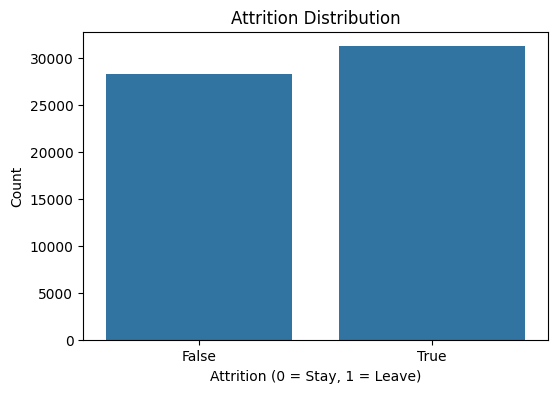

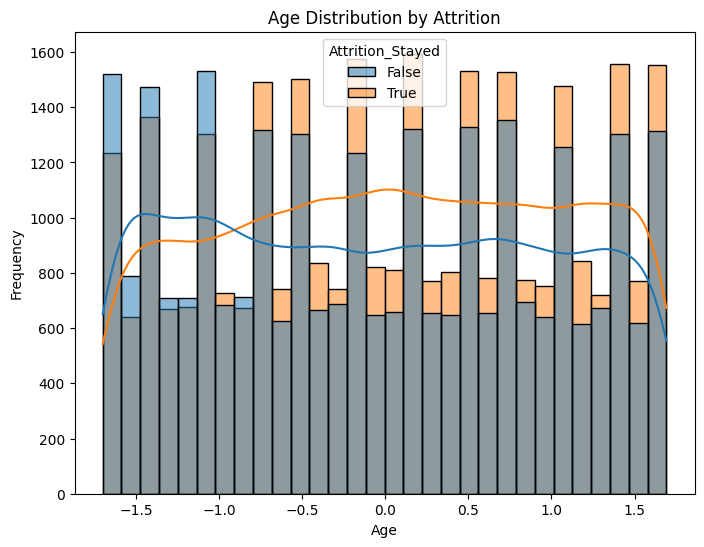

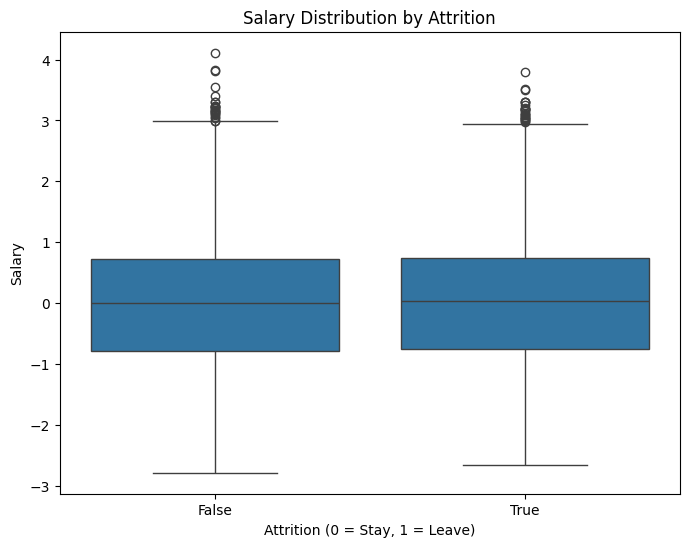

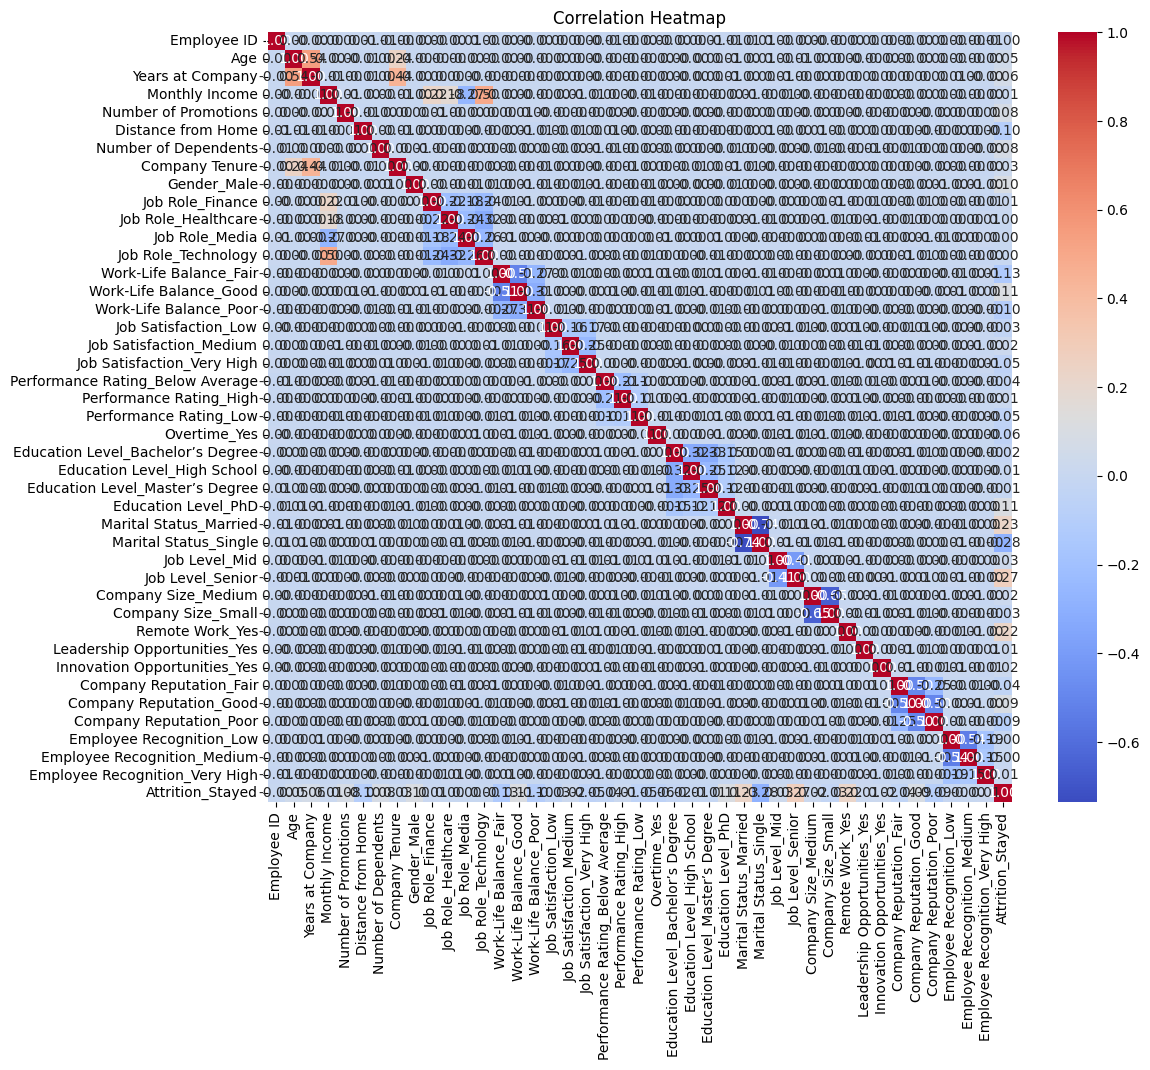

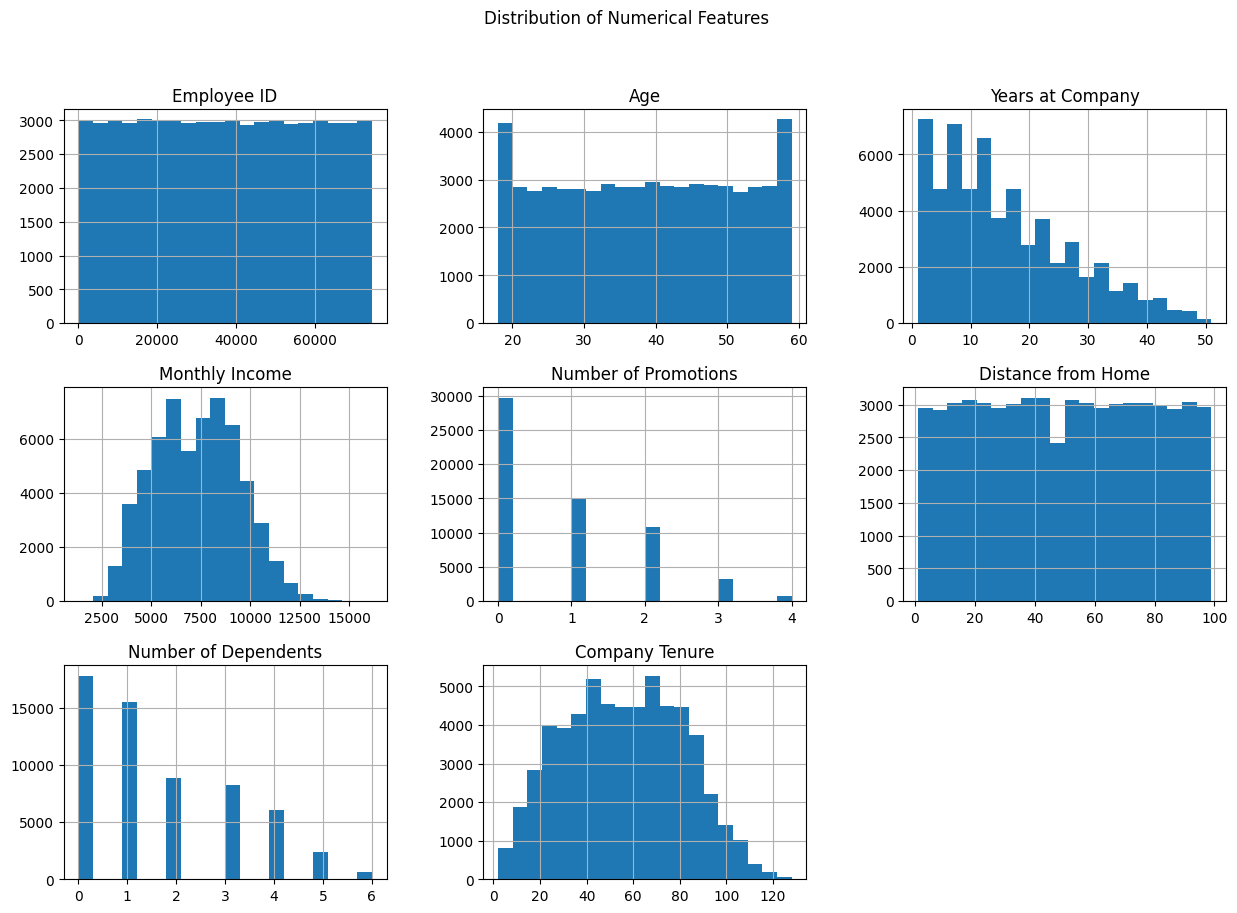

In [65]:
Att_var = df_train_encoded.filter(regex=r'^Attrition').columns[0]
print(Att_var)

# Visualization 1: Attrition Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=Att_var, data=df_train_encoded)
plt.title("Attrition Distribution")
plt.xlabel("Attrition (0 = Stay, 1 = Leave)")
plt.ylabel("Count")
plt.show()

# Visualization 2: Age Distribution by Attrition
plt.figure(figsize=(8, 6))
sns.histplot(data=df_train_encoded, x="Age", hue=Att_var, bins=30, kde=True)
plt.title("Age Distribution by Attrition")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Visualization 3: Salary Distribution by Attrition (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x= Att_var, y= "Monthly Income", data=df_train_encoded)
plt.title("Salary Distribution by Attrition")
plt.xlabel("Attrition (0 = Stay, 1 = Leave)")
plt.ylabel("Salary")
plt.show()

# Visualization 4: Correlation Heatmap of Encoded Features
plt.figure(figsize=(12, 10))
corr_matrix = df_train_encoded.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

numerical_features = df_train_encoded.select_dtypes(include=[np.number]).columns
df_train[numerical_features].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.show()


# Prediction Script

In [110]:
final_model = models_tuned["XGBoost"]

def predict_employee_attrition(employee_features, model, scaler, expected_cols, cat_cols, num_cols, threshold=0.6):
    # Ensure "Attrition" is not included in the categorical columns list
    cat_cols = [col for col in cat_cols if col != "Attrition"]
    
    # Convert the sample dictionary to a DataFrame
    df_sample = pd.DataFrame([employee_features])
    
    # One-hot encode the sample's categorical columns
    df_sample_encoded = pd.get_dummies(df_sample, columns=cat_cols, drop_first=True)
    
    # Reindex to ensure all expected columns are present (fill missing with 0)
    df_sample_encoded = df_sample_encoded.reindex(columns=expected_cols, fill_value=0)
    
    # Scale the numerical columns using the pre-fitted scaler
    df_sample_encoded[num_cols] = scaler.transform(df_sample_encoded[num_cols])
    
    # Get predicted probability and apply threshold
    prediction_prob = model.predict_proba(df_sample_encoded)[:, 1]
    adjusted_prediction = (prediction_prob >= threshold).astype(int)[0]
    
    return int(adjusted_prediction), float(prediction_prob[0])

# Pull a random employee from the test set
random_index = np.random.choice(df_test.index)
random_employee = df_test.loc[random_index].to_dict()
actual_attrition = random_employee.pop("Attrition")

# Convert the actual attrition to numeric: assume "Leave" means 1 and "Stay" means 0
if isinstance(actual_attrition, str):
    actual_attrition = 1 if actual_attrition.lower() in ["leave", "yes"] else 0

print("Random Employee Data:")
print(random_employee)
print("Actual Attrition:", "Leave" if actual_attrition == 1 else "Stay")

# Ensure the categorical columns list doesn't include 'Attrition'
cat_cols_filtered = [col for col in list(cat_cols_train) if col != "Attrition"]

prediction, probability = predict_employee_attrition(
    random_employee,
    final_model,
    scaler,
    X_train.columns,      # expected columns from the encoded training data
    cat_cols_filtered,    # filtered categorical columns from training data
    num_cols_encoded,     # numerical columns from the encoded training data
    threshold=0.8
)
result = "Leave" if prediction == 1 else "Stay"
print("\nPrediction for random employee:", result)
print("Probability of leaving: {:.2f}".format(probability))
confidence = probability if probability >= 0.5 else 1 - probability
print("Model Confidence: {:.2f}%".format(confidence * 100))
print("Prediction is", "correct." if prediction == actual_attrition else "incorrect.")


Random Employee Data:
{'Employee ID': 16420, 'Age': 47, 'Gender': 'Female', 'Years at Company': 26, 'Job Role': 'Education', 'Monthly Income': 5573, 'Work-Life Balance': 'Excellent', 'Job Satisfaction': 'High', 'Performance Rating': 'High', 'Number of Promotions': 0, 'Overtime': 'No', 'Distance from Home': 18, 'Education Level': 'Associate Degree', 'Marital Status': 'Single', 'Number of Dependents': 4, 'Job Level': 'Entry', 'Company Size': 'Medium', 'Company Tenure': 102, 'Remote Work': 'Yes', 'Leadership Opportunities': 'No', 'Innovation Opportunities': 'No', 'Company Reputation': 'Good', 'Employee Recognition': 'Medium'}
Actual Attrition: Stay

Prediction for random employee: Leave
Probability of leaving: 0.89
Model Confidence: 89.36%
Prediction is incorrect.


In [115]:
# Pull a random employee from the test set and prepare the raw data
random_index = np.random.choice(df_test.index)
random_employee = df_test.loc[random_index].to_dict()
actual_attrition = random_employee.pop("Attrition")

# Convert actual attrition to numeric (assuming "Leave"/"Yes" -> 1, "Stay"/"No" -> 0)
if isinstance(actual_attrition, str):
    actual_attrition = 1 if actual_attrition.lower() in ["leave", "yes"] else 0

print("Random Employee Data:")
print(random_employee)
print("Actual Attrition:", "Leave" if actual_attrition == 1 else "Stay")

# Filter categorical columns (remove 'Attrition' if present)
cat_cols_filtered = [col for col in list(cat_cols_train) if col != "Attrition"]

# Dictionary to store predictions for each model
predictions = {}

for model_name, model in models_tuned.items():
    pred, prob = predict_employee_attrition(
        random_employee,
        model,
        scaler,
        X_train.columns,      # Expected columns from training (after encoding)
        cat_cols_filtered,    # Filtered categorical columns
        num_cols_encoded,     # Numerical columns from the encoded training data
        threshold=0.8         # Custom threshold (adjust as needed)
    )
    predictions[model_name] = {
        "Prediction": "Leave" if pred == 1 else "Stay",
        "Probability": prob,
        "Confidence": prob if prob >= 0.5 else 1 - prob,
        "Correct": (pred == actual_attrition)
    }

# Print predictions for each model
for model_name, result in predictions.items():
    print(f"\nModel: {model_name}")
    print("Prediction:", result["Prediction"])
    print("Probability of leaving: {:.2f}".format(result["Probability"]))
    print("Model Confidence: {:.2f}%".format(result["Confidence"] * 100))
    print("Prediction is", "correct." if result["Correct"] else "incorrect.")


Random Employee Data:
{'Employee ID': 15119, 'Age': 41, 'Gender': 'Male', 'Years at Company': 4, 'Job Role': 'Finance', 'Monthly Income': 11863, 'Work-Life Balance': 'Fair', 'Job Satisfaction': 'Medium', 'Performance Rating': 'Average', 'Number of Promotions': 0, 'Overtime': 'Yes', 'Distance from Home': 56, 'Education Level': 'Master’s Degree', 'Marital Status': 'Married', 'Number of Dependents': 0, 'Job Level': 'Entry', 'Company Size': 'Large', 'Company Tenure': 5, 'Remote Work': 'No', 'Leadership Opportunities': 'No', 'Innovation Opportunities': 'No', 'Company Reputation': 'Good', 'Employee Recognition': 'High'}
Actual Attrition: Stay

Model: Random Forest
Prediction: Stay
Probability of leaving: 0.36
Model Confidence: 63.66%
Prediction is correct.

Model: Gradient Boosting
Prediction: Stay
Probability of leaving: 0.30
Model Confidence: 69.54%
Prediction is correct.

Model: XGBoost
Prediction: Stay
Probability of leaving: 0.47
Model Confidence: 53.33%
Prediction is correct.


In [122]:
# Number of iterations to test random employees
n_iterations = 100

# Dictionaries to store summary metrics and details of wrong predictions for each model
summary = {}
wrong_predictions = {}

# Loop over each tuned model
for model_name, model in models_tuned.items():
    correct_count = 0
    total_probability = 0.0
    total_confidence = 0.0
    wrong_details = []  # will store details for each wrong prediction
    
    # Perform predictions for a number of random employees
    for i in range(n_iterations):
        # Pick a random employee from the raw test DataFrame
        random_index = np.random.choice(df_test.index)
        random_employee = df_test.loc[random_index].to_dict()
        
        # Remove the target value and store it separately
        actual_attrition = random_employee.pop("Attrition")
        # Convert the actual attrition to numeric (assume "Leave"/"Yes" -> 1, "Stay"/"No" -> 0)
        if isinstance(actual_attrition, str):
            actual_attrition = 1 if actual_attrition.lower() in ["leave", "yes"] else 0
        
        # Get prediction and probability using the tuned model
        pred, prob = predict_employee_attrition(
            random_employee,
            model,
            scaler,
            X_train.columns,         # expected columns from training (after encoding)
            list(cat_cols_train),    # original categorical columns from training
            num_cols_encoded,        # numerical columns from the encoded training data
            threshold=0.8             # adjust threshold as needed
        )
        # Define confidence as the distance from 0.5
        confidence = prob if prob >= 0.5 else 1 - prob
        
        total_probability += prob
        total_confidence += confidence
        
        if pred == actual_attrition:
            correct_count += 1
        else:
            wrong_details.append({
                "Iteration": i,
                "Employee Index": random_index,
                "Predicted": pred,
                "Actual": actual_attrition,
                "Probability": prob,
                "Confidence": confidence,
                "Employee Data": random_employee
            })
    
    # Compute summary metrics for the current model
    accuracy_model = correct_count / n_iterations
    avg_probability = total_probability / n_iterations
    avg_confidence = total_confidence / n_iterations
    
    summary[model_name] = {
         "Accuracy": accuracy_model,
         "Average Probability": avg_probability,
         "Average Confidence": avg_confidence,
         "Total Wrong Predictions": n_iterations - correct_count
    }
    wrong_predictions[model_name] = wrong_details

# Print overall summary for each model as a DataFrame
summary_df = pd.DataFrame(summary).T  # transpose to have models as rows
print("Summary for each model over", n_iterations, "iterations:")
print(summary_df)

# Print detailed summary for wrong predictions for each model
for model_name, details in wrong_predictions.items():
    print("\nWrong Predictions for", model_name)
    if details:
         df_wrong = pd.DataFrame(details)
         print(df_wrong)
    else:
         print("None")


Summary for each model over 100 iterations:
                   Accuracy  Average Probability  Average Confidence  \
Random Forest          0.97             0.634936            0.645021   
Gradient Boosting      0.87             0.592385            0.644867   
XGBoost                0.82             0.690907            0.697655   

                   Total Wrong Predictions  
Random Forest                          3.0  
Gradient Boosting                     13.0  
XGBoost                               18.0  

Wrong Predictions for Random Forest
   Iteration  Employee Index  Predicted  Actual  Probability  Confidence  \
0         25            5953          1       0     0.805698    0.805698   
1         29            4304          1       0     0.845200    0.845200   
2         37            8340          1       0     0.829826    0.829826   

                                       Employee Data  
0  {'Employee ID': 32258, 'Age': 35, 'Gender': 'F...  
1  {'Employee ID': 3726, 'Age': 44,